In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# 1. Paths and sensor->subsystem mapping
TRAIN_PATH = 'train_FD001.txt'
TEST_PATH  = 'test_FD001.txt'
TRUTH_PATH = 'RUL_FD001.txt'

# Sensor to subsystem mapping provided by user
SENSOR_TO_SUBSYSTEM = {
    'sensor_1': ['Fan inlet temperature', 'Overall Inlet'],
    'sensor_2': ['Fan inlet pressure (psia)', 'Overall Inlet'],
    'sensor_3': ['HPC outlet pressure (psia)','High-Pressure Compressor (HPC)'],
    'sensor_4': ['HPT outlet temperature','High-Pressure Turbine (HPT)'],
    'sensor_5': ['LPC outlet temperature','Low-Pressure Compressor (LPC)'],
    'sensor_6': ['Fan speed rpm','Fan'],
    'sensor_7': ['Fan inlet pressure (psia)', 'Overall Inlet'],
    'sensor_8': ['HPC outlet static pressure (psia)','High-Pressure Compressor (HPC)'],
    'sensor_9': ['Corrected fan speed (rpm)','Fan'],
    'sensor_10': ['Ratio of pressure (bypass)Fan', 'Overall'],
    'sensor_11': ['Fuel flow (pph)','Combustion Chamber'],
    'sensor_12': ['LPC outlet temperature (corrected)','Low-Pressure Compressor (LPC)'],
    'sensor_13': ['HPT outlet temperature (corrected)','High-Pressure Turbine (HPT)'],
    'sensor_14': ['Physical fan speed (rpm)','Fan'],
    'sensor_15': ['Physical core engine speed (rpm)','High-Pressure Compressor (HPC) and High-Pressure Turbine (HPT)'],
    'sensor_16': ['Bleed air (units)','Overall Engine System'],
    'sensor_17': ['Fuel-air ratio','Combustion Chamber'],
    'sensor_18': ['Thrust-specific fuel consumption (TSFC)','Overall Engine System'],
    'sensor_19': ['Total temperature at LPC exit','Low-Pressure Compressor (LPC)'],
    'sensor_20': ['Engine pressure ratio','Overall Engine System'],
    'sensor_21': ['Total temperature at HPT exit ','High-Pressure Turbine (HPT)']
}

# 2. Load & preprocess data (features scaled; RUL kept in cycles)
train = pd.read_csv(TRAIN_PATH, sep=' ', header=None)
train.drop([26,27], axis=1, inplace=True)
cols = ['engine_id','cycle'] + [f'op_setting_{i+1}' for i in range(3)] + [f'sensor_{i+1}' for i in range(21)]
train.columns = cols

rul_df = train.groupby('engine_id')['cycle'].max().reset_index()
rul_df.columns = ['engine_id', 'max_cycle']
train = train.merge(rul_df, on='engine_id')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

MAX_RUL = 125
train['RUL'] = train['RUL'].clip(upper=MAX_RUL)

feature_cols = train.columns[2:-1]
scaler = MinMaxScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])

# test & truth
test = pd.read_csv(TEST_PATH, sep=' ', header=None)
test.drop([26,27], axis=1, inplace=True)
test.columns = cols

truth = pd.read_csv(TRUTH_PATH, header=None)
truth.columns = ['RUL']

# scale test
test[feature_cols] = scaler.transform(test[feature_cols])

In [3]:
# 3. Sequence creation helpers
SEQ_LEN = 30

def create_sequences(df, seq_length=SEQ_LEN):
    X, y = [], []
    for eid in df['engine_id'].unique():
        ed = df[df['engine_id']==eid].reset_index(drop=True)
        for i in range(len(ed)-seq_length):
            X.append(ed.iloc[i:i+seq_length][feature_cols].values)
            y.append(ed.iloc[i+seq_length]['RUL'])
    return np.array(X), np.array(y)

def create_sequences_test_last(df, seq_length=SEQ_LEN):
    X, engine_ids = [], []
    for eid in df['engine_id'].unique():
        ed = df[df['engine_id']==eid].reset_index(drop=True)
        if len(ed) >= seq_length:
            X.append(ed.iloc[-seq_length:][feature_cols].values)
            engine_ids.append(eid)
    return np.array(X), np.array(engine_ids)

X, y = create_sequences(train, SEQ_LEN)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, test_engine_ids = create_sequences_test_last(test, SEQ_LEN)
true_rul_test = truth['RUL'].values[:len(test_engine_ids)]
print('Shapes -', X_train.shape, X_val.shape, X_test.shape)

Shapes - (14104, 30, 24) (3527, 30, 24) (100, 30, 24)


In [4]:
# 4. Dataset & dataloader
class RUL_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1,1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH = 64
train_loader = DataLoader(RUL_Dataset(X_train, y_train), batch_size=BATCH, shuffle=True)
val_loader = DataLoader(RUL_Dataset(X_val, y_val), batch_size=BATCH, shuffle=False)

In [6]:
# 5. Model definition (parameterize cnn_channels)
class CNNTransformerModel(nn.Module):
    def __init__(self, input_dim, cnn_channels=64, d_model=128, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.input_proj = nn.Linear(cnn_channels, d_model)
        self.fc = nn.Sequential(nn.Linear(d_model,64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64,1))

    def forward(self, x):
        x = x.permute(0,2,1)  # [B, F, T]
        x = self.cnn(x)       # [B, C, T]
        x = x.permute(0,2,1)  # [B, T, C]
        x = self.input_proj(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)

In [7]:
# 6. Asymmetric loss and metrics
mse_loss = nn.MSELoss()

def asymmetric_loss(pred, true, lambda_over=10.0):
    base = mse_loss(pred, true)
    over_pen = torch.relu(pred - true)
    over_term = (over_pen**2).mean()
    return base + lambda_over * over_term

def compute_overestimation_rate(preds, trues):
    over = (preds - trues) > 0
    return float(over.sum()) / len(over)

# Modified asymmetric loss to weight by true RUL
def weighted_asymmetric_loss(pred, true, lambda_over=10.0, max_rul=125):
    """
    - Penalizes overestimation (lambda_over)
    - Gives higher weight to high RUL samples
    """
    base = mse_loss(pred, true)
    over_pen = torch.relu(pred - true)
    over_term = (over_pen**2).mean()
    
    # Weight by true RUL (normalized)
    weight = (true / max_rul).view(-1,1)  # shape [batch_size,1]
    weighted_base = (weight * (pred - true)**2).mean()
    
    return weighted_base + lambda_over * over_term

In [8]:
# 7. Training & evaluation functions

def train_one_epoch(model, loader, optimizer, lambda_over):
    model.train()
    total = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = asymmetric_loss(preds, yb, lambda_over=lambda_over)
        loss.backward()
        optimizer.step()
        total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)

def train_one_epoch_weighted(model, loader, optimizer, lambda_over, max_rul=125):
    model.train()
    total = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = weighted_asymmetric_loss(preds, yb, lambda_over=lambda_over, max_rul=max_rul)
        loss.backward()
        optimizer.step()
        total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)


def evaluate(model, loader):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            all_preds.append(preds.cpu().numpy().flatten())
            all_trues.append(yb.cpu().numpy().flatten())
    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)
    val_mse = mean_squared_error(all_trues, all_preds)
    over_rate = compute_overestimation_rate(all_preds, all_trues)
    return val_mse, over_rate, all_preds, all_trues

In [9]:
# 8. Hyperparameter grid search
search_space = {
    'lr': [1e-3, 5e-4],
    'lambda_over': [5.0, 10.0, 20.0],
    'cnn_channels': [32, 64]
}

BEST_DIR = 'hp_search_results'
os.makedirs(BEST_DIR, exist_ok=True)

results = []

for lr in search_space['lr']:
    for lambda_over in search_space['lambda_over']:
        for cnn_ch in search_space['cnn_channels']:
            print(f"Running grid point lr={lr}, lambda_over={lambda_over}, cnn_ch={cnn_ch}")
            model = CNNTransformerModel(input_dim=len(feature_cols), cnn_channels=cnn_ch).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            EPOCHS = 25
            best_val_obj = float('inf')
            patience = 6
            no_improve = 0
            for epoch in range(EPOCHS):
                train_obj = train_one_epoch_weighted(model, train_loader, optimizer, lambda_over)
                val_mse, val_over, _, _ = evaluate(model, val_loader)
                # objective combines MSE and over-rate penalty
                val_obj = val_mse + 1000.0 * val_over
                print(f"  Epoch {epoch+1}/{EPOCHS} train_obj={train_obj:.4f} val_mse={val_mse:.4f} val_over={val_over:.3f} val_obj={val_obj:.4f}")
                if val_obj < best_val_obj:
                    best_val_obj = val_obj
                    torch.save(model.state_dict(), os.path.join(BEST_DIR, f"best_lr{lr}_lam{lambda_over}_ch{cnn_ch}.pth"))
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        print("  Early stopping")
                        break
            # after training, load best and evaluate
            model.load_state_dict(torch.load(os.path.join(BEST_DIR, f"best_lr{lr}_lam{lambda_over}_ch{cnn_ch}.pth"), map_location=device))
            val_mse, val_over, val_preds, val_trues = evaluate(model, val_loader)
            results.append({'lr': lr, 'lambda_over': lambda_over, 'cnn_ch': cnn_ch,
                            'val_mse': val_mse, 'val_over': val_over, 'val_obj': val_mse + 1000.0*val_over})
            # save summary CSV per grid point
            pd.DataFrame(results).to_csv(os.path.join(BEST_DIR, 'grid_search_summary.csv'), index=False)

# print sorted results
res_df = pd.DataFrame(results).sort_values('val_obj')
print('Top grid results:')
print(res_df.head())

Running grid point lr=0.001, lambda_over=5.0, cnn_ch=32
  Epoch 1/25 train_obj=2722.8440 val_mse=704.9316 val_over=0.143 val_obj=848.1128
  Epoch 2/25 train_obj=687.6806 val_mse=481.7827 val_over=0.150 val_obj=632.0521
  Epoch 3/25 train_obj=574.5867 val_mse=350.5839 val_over=0.177 val_obj=528.0719
  Epoch 4/25 train_obj=541.6321 val_mse=371.2233 val_over=0.152 val_obj=523.1938
  Epoch 5/25 train_obj=534.9472 val_mse=291.4579 val_over=0.283 val_obj=574.1344
  Epoch 6/25 train_obj=507.0029 val_mse=353.2852 val_over=0.160 val_obj=513.7615
  Epoch 7/25 train_obj=508.6643 val_mse=239.8095 val_over=0.301 val_obj=541.1988
  Epoch 8/25 train_obj=522.7853 val_mse=302.3861 val_over=0.232 val_obj=534.0277
  Epoch 9/25 train_obj=487.3038 val_mse=320.4264 val_over=0.237 val_obj=557.1715
  Epoch 10/25 train_obj=481.1050 val_mse=356.4915 val_over=0.137 val_obj=493.1515
  Epoch 11/25 train_obj=488.6504 val_mse=388.5630 val_over=0.145 val_obj=534.0123
  Epoch 12/25 train_obj=493.0049 val_mse=323.7140 

In [10]:
# 9. Load best hyperparameters & final evaluation on test
best = res_df.iloc[0]
print('Selected best config:', best.to_dict())
best_model_path = os.path.join(BEST_DIR, f"best_lr{best['lr']}_lam{best['lambda_over']}_ch{int(best['cnn_ch'])}.pth")
model = CNNTransformerModel(input_dim=len(feature_cols), cnn_channels=int(best['cnn_ch'])).to(device)
model.load_state_dict(torch.load(best_model_path, map_location=device))

# test predictions
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred_test = model(X_test_t).cpu().numpy().flatten()

rmse_test = math.sqrt(mean_squared_error(true_rul_test, y_pred_test))
over_test = compute_overestimation_rate(y_pred_test, true_rul_test)
print(f"Final Test RMSE: {rmse_test:.3f}  Overestimation rate: {over_test*100:.2f}%")

results_df = pd.DataFrame({'engine_id': test_engine_ids, 'true_RUL': true_rul_test, 'predicted_RUL': y_pred_test})
results_df['error'] = results_df['predicted_RUL'] - results_df['true_RUL']
results_df.to_csv('final_predictions.csv', index=False)

Selected best config: {'lr': 0.0005, 'lambda_over': 5.0, 'cnn_ch': 64.0, 'val_mse': 119.49762725830078, 'val_over': 0.12049900765523107, 'val_obj': 239.99663491353186}
Final Test RMSE: 19.244  Overestimation rate: 29.00%


In [11]:
# 10. Attribution (SmoothGrad Grad x Input) and mapping to subsystems

def compute_grad_times_input_smooth_single(model, x_np, n_samples=12, stdev=1e-3):
    model.eval()
    X = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0).to(device)
    accum = np.zeros_like(x_np)
    for _ in range(n_samples):
        noise = torch.randn_like(X) * stdev
        Xn = (X + noise).clone().detach().requires_grad_(True)
        out = model(Xn)
        out.sum().backward()
        grads = Xn.grad.detach().cpu().numpy()[0]
        inputs = Xn.detach().cpu().numpy()[0]
        accum += np.abs(grads * inputs)
    return accum / n_samples

reports = []
THRESHOLD_RUL_FLAG = 30
for i, (eid, pred, true_rul) in enumerate(zip(test_engine_ids, y_pred_test, true_rul_test)):
    attr_map = compute_grad_times_input_smooth_single(model, X_test[i])  # [seq_len, features]
    feat_imp = attr_map.sum(axis=0)
    feat_imp_norm = feat_imp / (feat_imp.sum() + 1e-12)
    top_idx = feat_imp_norm.argsort()[::-1][:5]
    top_sensors = [(feature_cols[idx], float(feat_imp_norm[idx])) for idx in top_idx]
    # map sensors to subsystems and aggregate
    subsystem_scores = {}
    for idx in range(len(feature_cols)):
        sname = feature_cols[idx]
        sensor_key = sname  # e.g., 'sensor_1'
        subs = SENSOR_TO_SUBSYSTEM.get(sensor_key, ['Unknown'])
        for sub in subs:
            subsystem_scores[sub] = subsystem_scores.get(sub, 0.0) + float(feat_imp_norm[idx])
    # sort subsystems
    subs_sorted = sorted(subsystem_scores.items(), key=lambda x: x[1], reverse=True)
    imminent = bool(pred <= THRESHOLD_RUL_FLAG)
    reports.append({
        'engine_id': int(eid),
        'predicted_RUL': float(pred),
        'true_RUL': int(true_rul),
        'imminent_failure_flag': imminent,
        'top_sensors': top_sensors,
        'top_subsystems': subs_sorted[:5]
    })

reports_df = pd.DataFrame(reports)
reports_df.to_csv('engine_failure_reports.csv', index=False)

In [12]:
reports_df.head()

,engine_id,predicted_RUL,true_RUL,imminent_failure_flag,top_sensors,top_subsystems
0,1,116.805397,112,False,"[(sensor_12, 0.1319834537726383), (sensor_20, ...","[(High-Pressure Turbine (HPT), 0.1779383359747..."
1,2,117.342339,98,False,"[(sensor_12, 0.09249203067615933), (sensor_6, ...","[(High-Pressure Turbine (HPT), 0.1875233447494..."
2,3,43.413326,69,False,"[(sensor_13, 0.09259713108092871), (sensor_12,...","[(High-Pressure Turbine (HPT), 0.2382284805326..."
3,4,99.544991,82,False,"[(sensor_12, 0.0855312724950233), (sensor_11, ...","[(High-Pressure Turbine (HPT), 0.2015404441133..."
4,5,77.641121,91,False,"[(sensor_12, 0.08982118033925357), (sensor_11,...","[(High-Pressure Turbine (HPT), 0.1867573314171..."


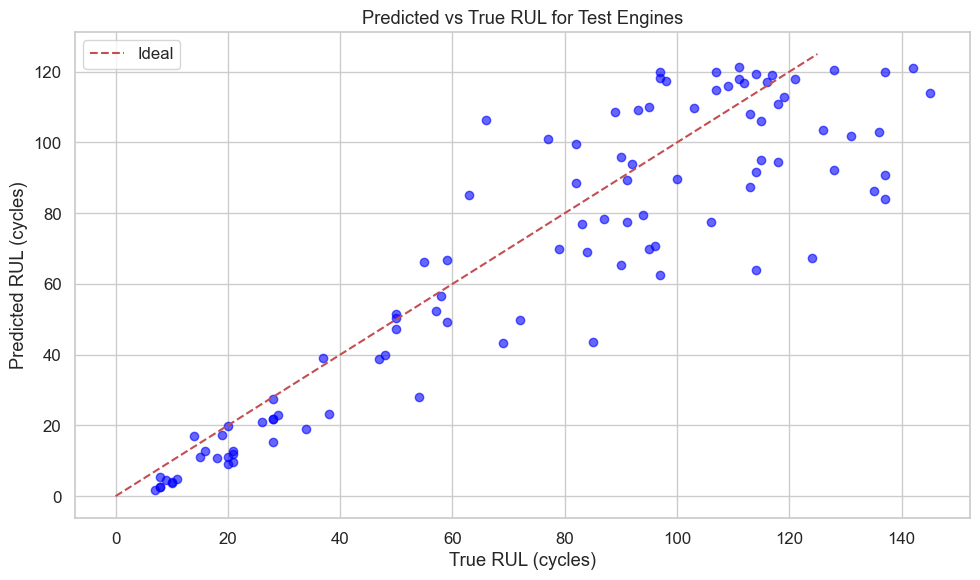

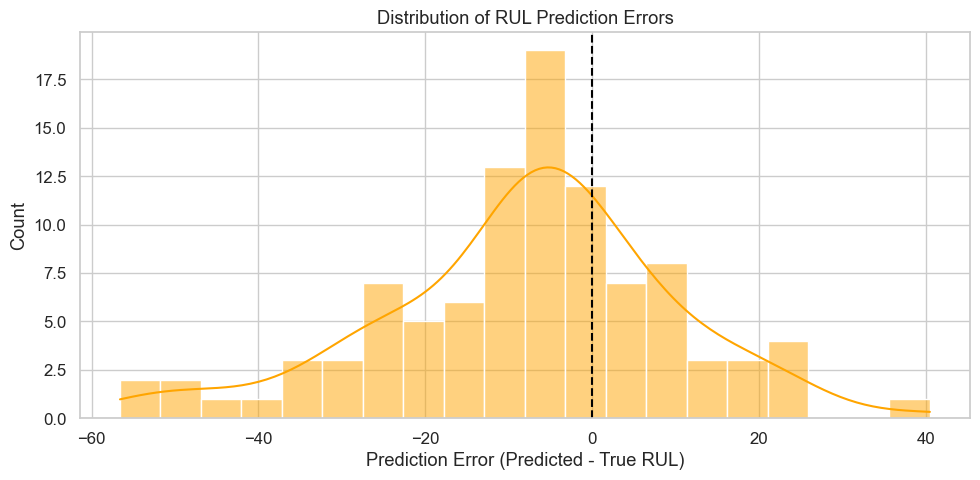

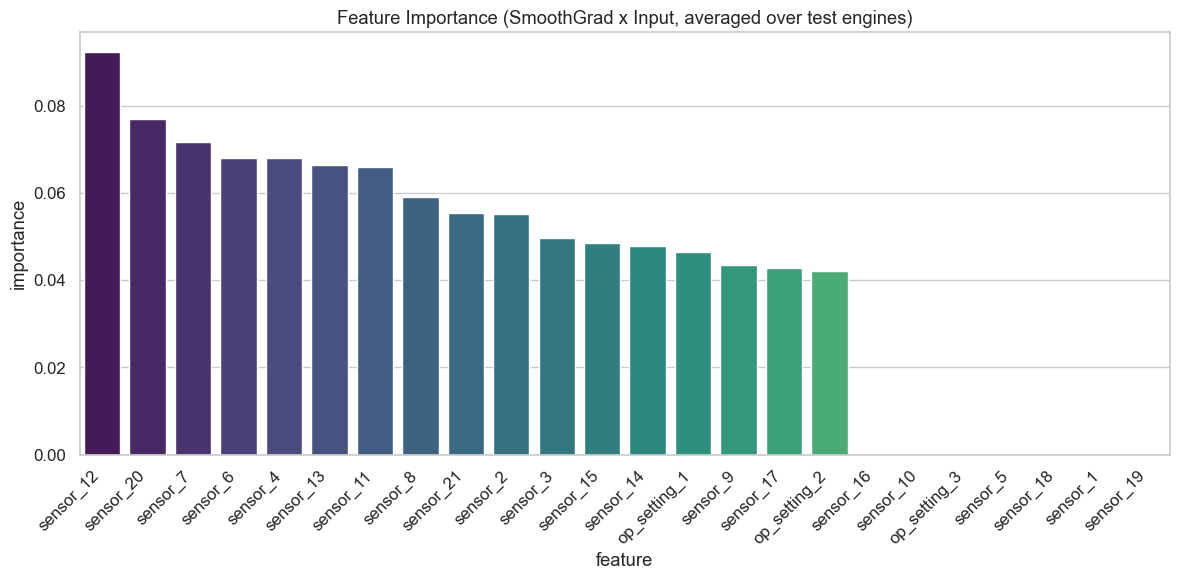

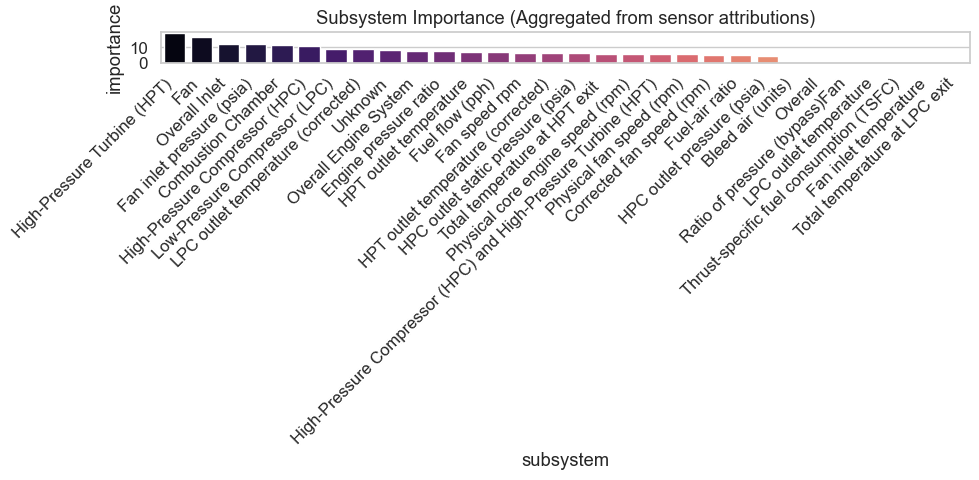

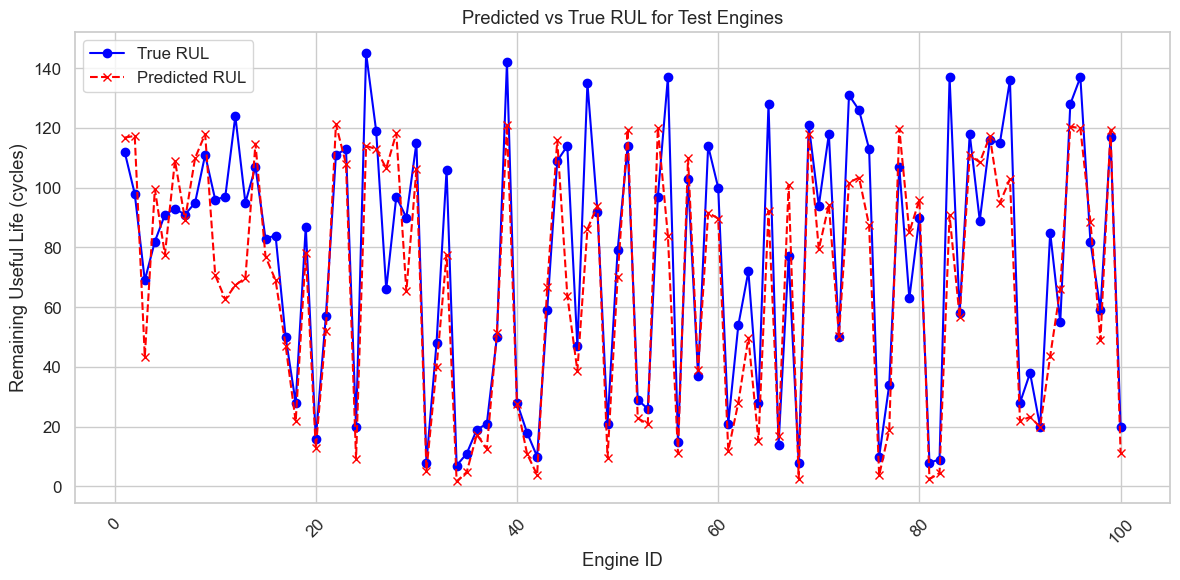

In [14]:
# === 12. Visualization for LinkedIn / Reports ===

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

# 12.1 True vs Predicted RUL for test engines
plt.figure(figsize=(10,6))
plt.scatter(results_df['true_RUL'], results_df['predicted_RUL'], c='blue', alpha=0.6)
plt.plot([0, MAX_RUL],[0, MAX_RUL], 'r--', label='Ideal')
plt.xlabel("True RUL (cycles)")
plt.ylabel("Predicted RUL (cycles)")
plt.title("Predicted vs True RUL for Test Engines")
plt.legend()
plt.tight_layout()
plt.savefig("pred_vs_true_rul.png", dpi=150)
plt.show()


# 12.2 Error distribution across test engines
plt.figure(figsize=(10,5))
sns.histplot(results_df['error'], bins=20, kde=True, color='orange')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Prediction Error (Predicted - True RUL)")
plt.ylabel("Count")
plt.title("Distribution of RUL Prediction Errors")
plt.tight_layout()
plt.savefig("rul_error_distribution.png", dpi=150)
plt.show()


# 12.3 Feature importance (averaged across all engines)
avg_feat_imp = np.zeros(len(feature_cols))
for i in range(len(X_test)):
    attr_map = compute_grad_times_input_smooth_single(model, X_test[i])
    avg_feat_imp += attr_map.sum(axis=0)
avg_feat_imp /= len(X_test)
avg_feat_imp_norm = avg_feat_imp / (avg_feat_imp.sum() + 1e-12)

feat_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': avg_feat_imp_norm
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=feat_imp_df, x='feature', y='importance', palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance (SmoothGrad x Input, averaged over test engines)")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150)
plt.show()


# 12.4 Subsystem importance (aggregated over engines)
subsystem_scores = {}
for i in range(len(X_test)):
    attr_map = compute_grad_times_input_smooth_single(model, X_test[i])
    feat_imp = attr_map.sum(axis=0)
    feat_imp_norm = feat_imp / (feat_imp.sum() + 1e-12)
    for idx, sensor_key in enumerate(feature_cols):
        subs = SENSOR_TO_SUBSYSTEM.get(sensor_key, ['Unknown'])
        for sub in subs:
            subsystem_scores[sub] = subsystem_scores.get(sub, 0) + feat_imp_norm[idx]

subsystem_df = pd.DataFrame(list(subsystem_scores.items()), columns=['subsystem','importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=subsystem_df, x='subsystem', y='importance', palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title("Subsystem Importance (Aggregated from sensor attributions)")
plt.tight_layout()
plt.savefig("subsystem_importance.png", dpi=150)
plt.show()

# Line Graph: Predicted vs True RUL ===

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_engine_ids, true_rul_test, label='True RUL', marker='o', linestyle='-', color='blue')
plt.plot(test_engine_ids, y_pred_test, label='Predicted RUL', marker='x', linestyle='--', color='red')
plt.xlabel("Engine ID")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title("Predicted vs True RUL for Test Engines")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("linegraph_pred_vs_true_rul.png", dpi=150)
plt.show()